In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,precision_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
%matplotlib inline

In [2]:
import missingno as msno

# 1. 데이터 load

In [3]:
building = pd.read_csv("ashrae-energy-prediction/building_metadata.csv");
train = pd.read_csv("ashrae-energy-prediction/train.csv");
test = pd.read_csv("ashrae-energy-prediction/test.csv");
weather_train = pd.read_csv("ashrae-energy-prediction/weather_train.csv");
weather_test = pd.read_csv("ashrae-energy-prediction/weather_test.csv");
sample_submission = pd.read_csv("ashrae-energy-prediction/sample_submission.csv");

In [4]:
building.head(5)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
train.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [6]:
test.head(5)

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [7]:
weather_train.head(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [8]:
weather_test.head(5)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [9]:
sample_submission.head(5)

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


# 2. Data Merge

### 년/월/일/시/분/초 

In [10]:
train["year"] = (train["timestamp"].str[:4]).astype(int)
train["month"] = (train["timestamp"].str[5:7]).astype(int)
train["day"] = (train["timestamp"].str[8:10]).astype(int)
train["hour"] = (train["timestamp"].str[11:13]).astype(int)
train["minute"] = (train["timestamp"].str[14:16]).astype(int)
train["second"] = (train["timestamp"].str[17:19]).astype(int)

In [11]:
merge_train = pd.merge(train, building,how="left",on="building_id")
merge_train = pd.merge(merge_train, weather_train,how="left",on=["site_id","timestamp"])
merge_train.head(5)

,building_id,meter,timestamp,meter_reading,year,month,day,hour,minute,second,...,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,2016,1,1,0,0,0,...,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,2016,1,1,0,0,0,...,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,2016,1,1,0,0,0,...,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,2016,1,1,0,0,0,...,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,2016,1,1,0,0,0,...,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


# 3. Data 시각화

### 사용처 LabelEncoder

In [12]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
merge_train["primary_use_label"] = label_encoder.fit_transform(merge_train['primary_use'])
primary_use =  merge_train[["primary_use","primary_use_label"]]
primary_use = primary_use.drop_duplicates().sort_values(by=['primary_use_label'], axis=0)
primary_use = primary_use.set_index("primary_use")
primary_use

,primary_use_label
primary_use,
Education,0
Entertainment/public assembly,1
Food sales and service,2
Healthcare,3
Lodging/residential,4
Manufacturing/industrial,5
Office,6
Other,7
Parking,8


In [13]:
merge_train["year"].unique()

array([2016], dtype=int64)

In [14]:
merge_train["minute"].unique()

array([0], dtype=int64)

In [15]:
merge_train["second"].unique()

array([0], dtype=int64)

### 연도(2016), 분(0), 초(0) 모두 데이터가 동일하기 때문에 의미없는 데이터로 판단

In [16]:
merge_train = merge_train.drop(["year","minute","second"],axis=1)

In [17]:
import seaborn as sns

[Text(0, 0.5, 'meter_reading'), Text(0.5, 1.0, 'time')]

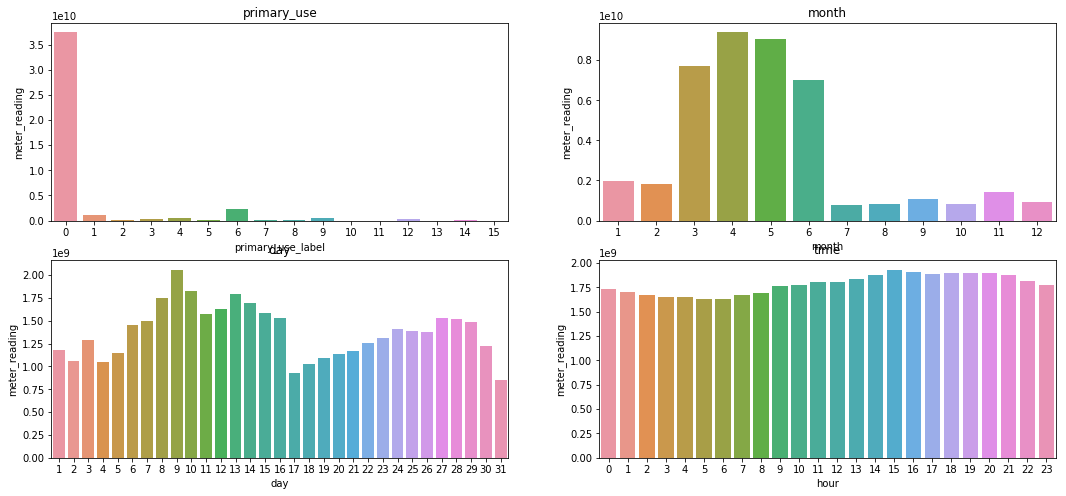

In [18]:
grp1 = merge_train[["month","meter_reading"]]
grp1 = grp1.groupby(["month"]).sum()
grp1["month"] = grp1.index
#sns.barplot(data=grp1, x="month", y="meter_reading")

grp2 = merge_train[["day","meter_reading"]]
grp2 = grp2.groupby(['day']).sum()
grp2["day"] = grp2.index
#sns.barplot(data=grp2, x="day", y="meter_reading")

grp3 = merge_train[["hour","meter_reading"]]
grp3 = grp3.groupby(['hour']).sum()
grp3["hour"] = grp3.index
#sns.barplot(data=grp3, x="hour", y="meter_reading")

grp4 = merge_train[["primary_use_label","meter_reading"]]
grp4 = grp4.groupby(['primary_use_label']).sum()
grp4["primary_use_label"] = grp4.index
#sns.barplot(data=grp4, x="primary_use", y="meter_reading")


figure, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2) # row 2개 col 3개로 표현
figure.set_size_inches(18,8)

sns.barplot(data=grp4, x="primary_use_label", y="meter_reading", ax=ax1)
sns.barplot(data=grp1, x="month", y="meter_reading", ax=ax2)
sns.barplot(data=grp2, x="day", y="meter_reading", ax=ax3)
sns.barplot(data=grp3, x="hour", y="meter_reading", ax=ax4)
         
ax1.set(ylabel='meter_reading', title= "primary_use")
ax2.set(ylabel='meter_reading', title= "month")
ax3.set(ylabel='meter_reading', title= "day")
ax4.set(ylabel='meter_reading', title= "time")

### - Education 건물이 가장 사용량이 높다.
월별 사용량은 3~6월에 가장 많고 7월이 가장 적다.
일별 사용랑과 시간별 사용량은 모두 비슷.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.p

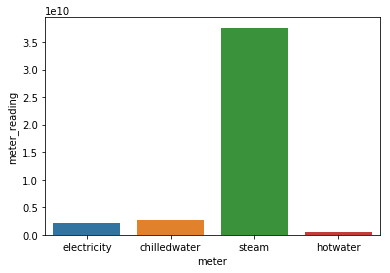

In [19]:
grp5 = merge_train[["meter","meter_reading"]]
grp5 = grp5.groupby(["meter"]).sum()
grp5["meter"] = grp5.index
grp5["meter"][0]= "electricity"
grp5["meter"][1]= "chilledwater"
grp5["meter"][2]= "steam"
grp5["meter"][3]= "hotwater"
sns.barplot(data=grp5, x="meter", y="meter_reading")

### 스팀 - 사용량이 가장 높다

# 3. 데이터 Null 처리

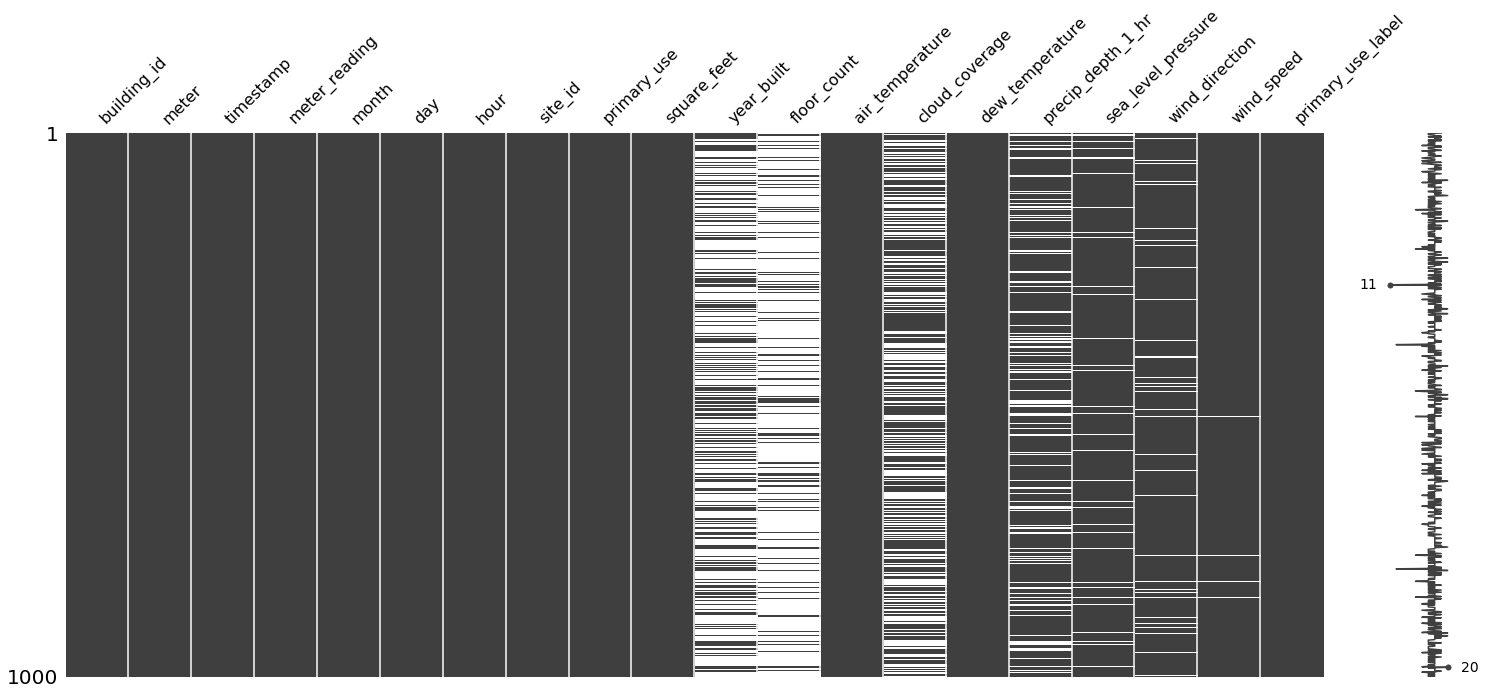

In [20]:
msno.matrix(merge_train.sample(1000))

### 공기 섭씨 온도 데이터 null 처리

In [21]:
weather_air_avg = merge_train[["site_id","month","day","air_temperature"]]  # 지역별 일자별 평균 날씨정보 입력
weather_air_avg = round(weather_air_avg.groupby(["site_id","month","day"]).mean(),2)
weather_air_avg.isna().sum()

air_temperature    0
dtype: int64

In [22]:
air_mapping = weather_air_avg.to_dict()
air_mapping = air_mapping["air_temperature"]
air_mapping

{(0, 1, 1): 23.34,
 (0, 1, 2): 19.54,
 (0, 1, 3): 14.83,
 (0, 1, 4): 12.67,
 (0, 1, 5): 14.06,
 (0, 1, 6): 15.53,
 (0, 1, 7): 16.49,
 (0, 1, 8): 17.48,
 (0, 1, 9): 17.34,
 (0, 1, 10): 19.25,
 (0, 1, 11): 11.49,
 (0, 1, 12): 10.7,
 (0, 1, 13): 11.74,
 (0, 1, 14): 13.1,
 (0, 1, 15): 18.73,
 (0, 1, 16): 18.42,
 (0, 1, 17): 17.13,
 (0, 1, 18): 11.15,
 (0, 1, 19): 9.46,
 (0, 1, 20): 9.44,
 (0, 1, 21): 13.24,
 (0, 1, 22): 16.93,
 (0, 1, 23): 10.69,
 (0, 1, 24): 6.34,
 (0, 1, 25): 10.17,
 (0, 1, 26): 16.04,
 (0, 1, 27): 18.33,
 (0, 1, 28): 18.0,
 (0, 1, 29): 15.23,
 (0, 1, 30): 13.9,
 (0, 1, 31): 15.89,
 (0, 2, 1): 20.5,
 (0, 2, 2): 21.39,
 (0, 2, 3): 23.24,
 (0, 2, 4): 22.93,
 (0, 2, 5): 13.34,
 (0, 2, 6): 12.82,
 (0, 2, 7): 10.65,
 (0, 2, 8): 10.51,
 (0, 2, 9): 13.26,
 (0, 2, 10): 10.84,
 (0, 2, 11): 9.88,
 (0, 2, 12): 13.72,
 (0, 2, 13): 16.49,
 (0, 2, 14): 13.4,
 (0, 2, 15): 17.37,
 (0, 2, 16): 19.73,
 (0, 2, 17): 16.04,
 (0, 2, 18): 16.72,
 (0, 2, 19): 16.37,
 (0, 2, 20): 17.15,
 (0, 2, 

## to_dict mulit key

In [23]:
merge_train["air_temperature2"] = merge_train.set_index(["site_id","month","day"]).index.map(air_mapping)
merge_train["air_temperature"].fillna(merge_train["air_temperature2"],inplace=True)
merge_train = merge_train.drop(["air_temperature2"],axis=1)
merge_train["air_temperature"].isna().sum()

0

## 구름의 양 데이터 null 처리

In [24]:
weather_cloud_avg_day = merge_train[["site_id","month","day","cloud_coverage"]]  # 지역별 일자별 평균 날씨정보 입력
weather_cloud_avg_day = round(weather_cloud_avg_day.groupby(["site_id","month","day"]).mean(),2)
weather_cloud_avg_day.isna().sum()

cloud_coverage    1075
dtype: int64

In [25]:
weather_cloud_avg_month = merge_train[["site_id","month","cloud_coverage"]]  # 지역별 일자별 평균 날씨정보 입력
weather_cloud_avg_month = round(weather_cloud_avg_month.groupby(["site_id","month"]).mean(),2)
weather_cloud_avg_month.isna().sum()

cloud_coverage    24
dtype: int64

In [26]:
weather_cloud_avg_site = merge_train[["site_id","cloud_coverage"]]
weather_cloud_avg_site = round(weather_cloud_avg_month.groupby(["site_id"]).mean(),2)
weather_cloud_avg_site.isna().sum()

cloud_coverage    2
dtype: int64

In [27]:
weather_cloud_avg = round(merge_train[["cloud_coverage"]].mean(),2)  # 지역별 일자별 평균 날씨정보 입력
weather_cloud_avg

cloud_coverage    1.9
dtype: float64

In [28]:
# 구름 월 기준
cloud_mapping1 = weather_cloud_avg_day.to_dict()
cloud_mapping1 = cloud_mapping1["cloud_coverage"]

# 구름 일 기준
cloud_mapping2 = weather_cloud_avg_month.to_dict()
cloud_mapping2 = cloud_mapping2["cloud_coverage"]

# 구름 일 기준
cloud_mapping3 = weather_cloud_avg_site.to_dict()
cloud_mapping3 = cloud_mapping3["cloud_coverage"]

In [29]:
merge_train["cloud_coverage2"] = merge_train.set_index(["site_id","month","day"]).index.map(cloud_mapping1)
merge_train["cloud_coverage3"] = merge_train.set_index(["site_id","month"]).index.map(cloud_mapping2)
merge_train["cloud_coverage4"] = merge_train.set_index(["site_id"]).index.map(cloud_mapping3)

merge_train["cloud_coverage"].fillna(merge_train["cloud_coverage2"],inplace=True)
merge_train["cloud_coverage"].fillna(merge_train["cloud_coverage3"],inplace=True)
merge_train["cloud_coverage"].fillna(merge_train["cloud_coverage4"],inplace=True)

merge_train["cloud_coverage"].fillna(2.15,inplace=True)
merge_train = merge_train.drop(["cloud_coverage2","cloud_coverage3","cloud_coverage4"],axis=1)
merge_train["cloud_coverage"].isna().sum()

0

### 습기 섭씨 온도 데이터 null 처리

In [30]:
weather_dew_avg = merge_train[["site_id","month","day","dew_temperature"]]  # 지역별 일자별 평균 날씨정보 입력
weather_dew_avg = round(weather_dew_avg.groupby(["site_id","month","day"]).mean(),2)
dew_mapping = weather_dew_avg.to_dict()
dew_mapping = dew_mapping["dew_temperature"]

merge_train["dew_temperature2"] = merge_train.set_index(["site_id","month","day"]).index.map(dew_mapping)

merge_train["dew_temperature"].fillna(merge_train["dew_temperature2"],inplace=True)
merge_train = merge_train.drop(["dew_temperature2"],axis=1)
merge_train["dew_temperature"].isna().sum()

0

### 시간당 강수량 데이터 null 처리

In [31]:
weather_precip_avg_day = merge_train[["site_id","month","day","precip_depth_1_hr"]]  # 지역별 일자별 평균 날씨정보 입력
weather_precip_avg_day = round(weather_precip_avg_day.groupby(["site_id","month","day"]).mean(),2)

weather_precip_avg_month = merge_train[["site_id","month","precip_depth_1_hr"]]  # 지역별 일자별 평균 날씨정보 입력
weather_precip_avg_month = round(weather_precip_avg_month.groupby(["site_id","month"]).mean(),2)

weather_precip_avg_site = merge_train[["site_id","precip_depth_1_hr"]]  # 지역별 일자별 평균 날씨정보 입력
weather_precip_avg_site = round(weather_precip_avg_site.groupby(["site_id"]).mean(),2)

weather_precip_avg =  round(merge_train[["precip_depth_1_hr"]].mean(),2)
weather_precip_avg

precip_depth_1_hr    0.8
dtype: float64

In [32]:
# 시간당 강수량 일 기준
precip_mapping1 = weather_precip_avg_day.to_dict()
precip_mapping1 = precip_mapping1["precip_depth_1_hr"]
# 시간당 강수량 월 기준
precip_mapping2 = weather_precip_avg_month.to_dict()
precip_mapping2 = precip_mapping2["precip_depth_1_hr"]

precip_mapping3 = weather_precip_avg_site.to_dict()
precip_mapping3 = precip_mapping3["precip_depth_1_hr"]

merge_train["precip_depth_1_hr1"] = merge_train.set_index(["site_id","month","day"]).index.map(precip_mapping1)
merge_train["precip_depth_1_hr2"] = merge_train.set_index(["site_id","month"]).index.map(precip_mapping2)
merge_train["precip_depth_1_hr3"] = merge_train.set_index(["site_id"]).index.map(precip_mapping3)

merge_train["precip_depth_1_hr"].fillna(merge_train["precip_depth_1_hr1"],inplace=True)
merge_train["precip_depth_1_hr"].fillna(merge_train["precip_depth_1_hr2"],inplace=True)
merge_train["precip_depth_1_hr"].fillna(merge_train["precip_depth_1_hr3"],inplace=True)

merge_train["precip_depth_1_hr"].fillna(0.98,inplace=True)
merge_train = merge_train.drop(["precip_depth_1_hr1","precip_depth_1_hr2","precip_depth_1_hr3"],axis=1)
merge_train["precip_depth_1_hr"].isna().sum()

0

### 해수면 압력 데이터 null 값 처리

In [33]:
weather_sea_avg_day = merge_train[["site_id","month","day","sea_level_pressure"]]  # 지역별 일자별 평균 날씨정보 입력
weather_sea_avg_day = round(weather_sea_avg_day.groupby(["site_id","month","day"]).mean(),2)

weather_sea_avg_month = merge_train[["site_id","month","sea_level_pressure"]]  # 지역별 일자별 평균 날씨정보 입력
weather_sea_avg_month = round(weather_sea_avg_month.groupby(["site_id","month"]).mean(),2)

weather_sea_avg_site = merge_train[["site_id","sea_level_pressure"]]  # 지역별 일자별 평균 날씨정보 입력
weather_sea_avg_site = round(weather_sea_avg_site.groupby(["site_id"]).mean(),2)

weather_sea_avg =  round(merge_train[["sea_level_pressure"]].mean(),2)
weather_sea_avg

sea_level_pressure    1016.09
dtype: float64

In [34]:
# 해수면 압력 일 기준
sea_level_mapping1 = weather_sea_avg_day.to_dict()
sea_level_mapping1 = sea_level_mapping1["sea_level_pressure"]
# 해수면 압력 월 기준
sea_level_mapping2 = weather_sea_avg_month.to_dict()
sea_level_mapping2 = sea_level_mapping2["sea_level_pressure"]
# 해수면 압력 site 기준
sea_level_mapping3 = weather_sea_avg_site.to_dict()
sea_level_mapping3 = sea_level_mapping3["sea_level_pressure"]

merge_train["sea_level_pressure2"] = merge_train.set_index(["site_id","month","day"]).index.map(sea_level_mapping1)
merge_train["sea_level_pressure3"] = merge_train.set_index(["site_id","month"]).index.map(sea_level_mapping2)
merge_train["sea_level_pressure4"] = merge_train.set_index(["site_id"]).index.map(sea_level_mapping3)

merge_train["sea_level_pressure"].fillna(merge_train["sea_level_pressure2"],inplace=True)
merge_train["sea_level_pressure"].fillna(merge_train["sea_level_pressure3"],inplace=True)
merge_train["sea_level_pressure"].fillna(merge_train["sea_level_pressure4"],inplace=True)

merge_train["sea_level_pressure"].fillna(1016.16,inplace=True)
merge_train = merge_train.drop(["sea_level_pressure2","sea_level_pressure3","sea_level_pressure4"],axis=1)
merge_train["sea_level_pressure"].isna().sum()

0

### 바람 방향 데이터 null 처리

In [35]:
# 바람 방향
weather_wind_direction_avg = merge_train[["site_id","month","day","wind_direction"]]  # 지역별 일자별 평균 날씨정보 입력
weather_wind_direction_avg = round(weather_wind_direction_avg.groupby(["site_id","month","day"]).mean(),2)
print(weather_wind_direction_avg.isna().sum())

# 해수면 압력 일 기준
wind_direction_mapping = weather_wind_direction_avg.to_dict()
wind_direction_mapping = wind_direction_mapping["wind_direction"]

merge_train["wind_direction2"] = merge_train.set_index(["site_id","month","day"]).index.map(wind_direction_mapping)

merge_train["wind_direction"].fillna(merge_train["wind_direction2"],inplace=True)
merge_train = merge_train.drop(["wind_direction2"],axis=1)
merge_train["wind_direction"].isna().sum()

wind_direction    0
dtype: int64


0

### 바람 속도 데이터 null 처리

In [36]:
weather_wind_speed_avg = merge_train[["site_id","month","day","wind_speed"]]  # 지역별 일자별 평균 날씨정보 입력
weather_wind_speed_avg = round(weather_wind_speed_avg.groupby(["site_id","month","day"]).mean(),2)

# 해수면 압력 일 기준
wind_speed_mapping = weather_wind_speed_avg.to_dict()
wind_speed_mapping = wind_speed_mapping["wind_speed"]

merge_train["wind_speed2"] = merge_train.set_index(["site_id","month","day"]).index.map(wind_speed_mapping)

merge_train["wind_speed"].fillna(merge_train["wind_speed2"],inplace=True)
merge_train = merge_train.drop(["wind_speed2"],axis=1)
merge_train["wind_speed"].isna().sum()

0

In [37]:
merge_train.isna().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
month                        0
day                          0
hour                         0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature              0
cloud_coverage               0
dew_temperature              0
precip_depth_1_hr            0
sea_level_pressure           0
wind_direction               0
wind_speed                   0
primary_use_label            0
dtype: int64

### building 데이터 null 처리

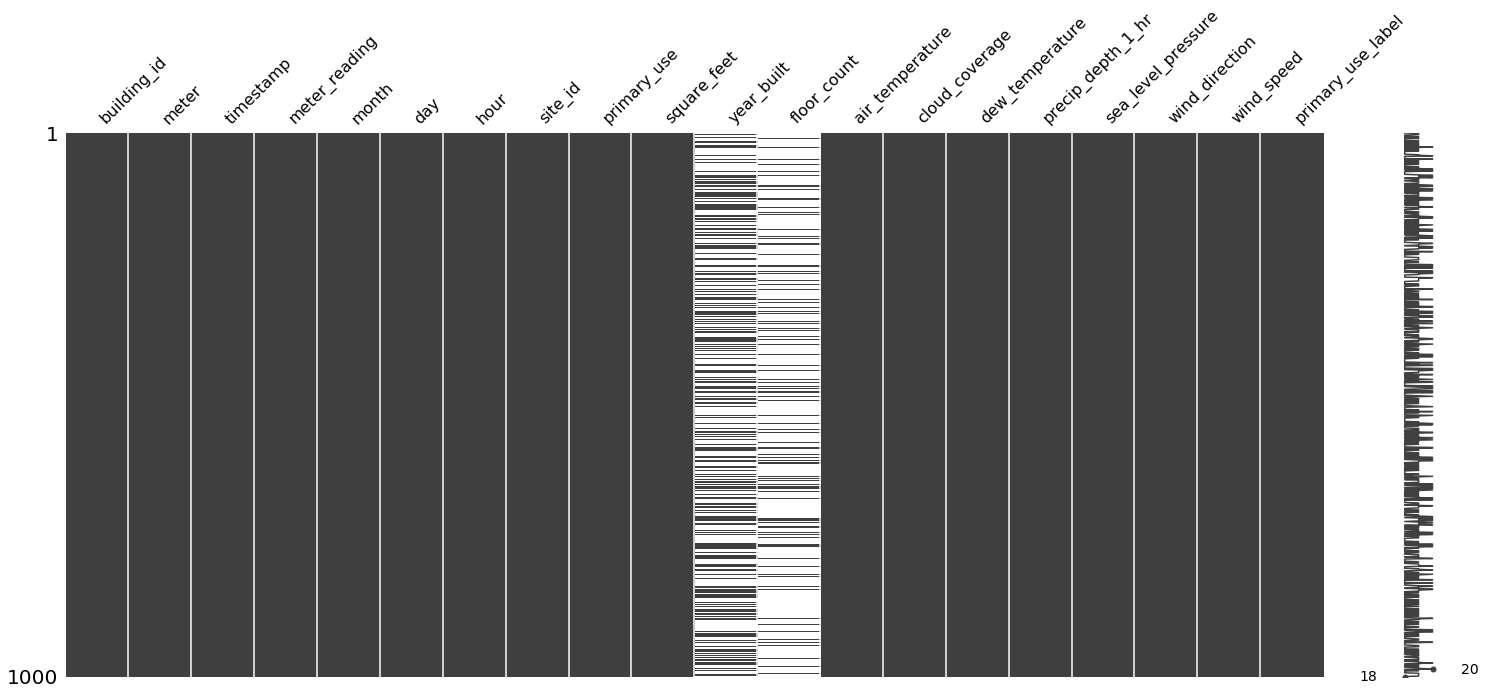

In [38]:
msno.matrix(merge_train.sample(1000))

### floor_count의 경우 null 값이 더 많아 불필요하다고 판단

In [39]:
merge_train = merge_train.drop(["floor_count"],axis=1)

### 건물 연식 데이터 null 처리

In [40]:
grp6 = merge_train[["site_id","year_built"]]
grp6 = grp6.groupby(["site_id"]).count()
grp6
#grp6["site_id"] = grp6.index
#sns.barplot(data=grp6, x="site_id", y="year_built")

,year_built
site_id,
0,1076662
1,412827
2,1948380
3,1133262
4,736951
5,772992
6,0
7,340707
8,0


### 연식 정보가 없는 site가 반(1/2)

In [41]:
# 지역, 용도 기준
building_year_site_avg = merge_train[["site_id","primary_use","year_built"]] 
building_year_site_avg = building_year_site_avg.groupby(["site_id","primary_use"]).mean()
# 지역 기준
building_year_site_avg = merge_train[["site_id","year_built"]] 
building_year_site_avg = building_year_site_avg.groupby(["site_id"]).mean()
# 용도 기준
building_year_primary_avg = merge_train[["primary_use","year_built"]] 
building_year_primary_avg = building_year_primary_avg.groupby(["primary_use"]).mean()
# 전체 평균
building_year_avg = round(merge_train[["year_built"]].mean(),0)

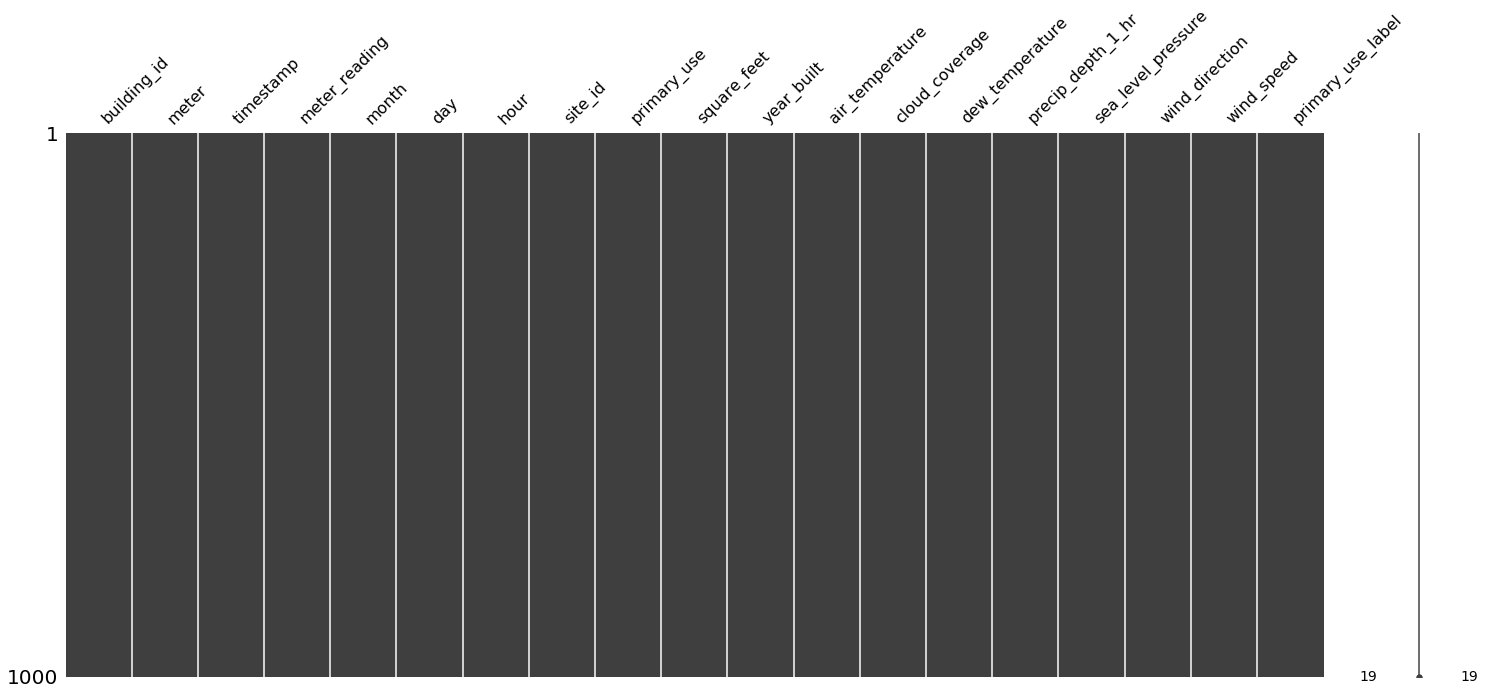

In [42]:
# site, 용도 별 평균
building_year_mapping1 = building_year_site_avg.to_dict()
building_year_mapping1 = building_year_mapping1["year_built"]
# site 평균
building_year_mapping2 = building_year_site_avg.to_dict()
building_year_mapping2 = building_year_mapping2["year_built"]
# 용도 평균
building_year_mapping3 = building_year_primary_avg.to_dict()
building_year_mapping3 = building_year_mapping3["year_built"]

merge_train["year_built2"] = merge_train.set_index(["site_id","primary_use"]).index.map(building_year_mapping1)
merge_train["year_built3"] = merge_train.set_index(["site_id"]).index.map(building_year_mapping2)
merge_train["year_built4"] = merge_train.set_index(["primary_use"]).index.map(building_year_mapping3)

merge_train["year_built"].fillna(round(merge_train["year_built2"],0),inplace=True)
merge_train["year_built"].fillna(round(merge_train["year_built3"],0),inplace=True)
merge_train["year_built"].fillna(round(merge_train["year_built4"],0),inplace=True)
merge_train["year_built"].fillna(1968.0,inplace=True)

# 생성햇던 데이터 삭제
merge_train = merge_train.drop(["year_built2","year_built3","year_built4"],axis=1)

msno.matrix(merge_train.sample(1000))

In [43]:
merge_train.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
month                 0
day                   0
hour                  0
site_id               0
primary_use           0
square_feet           0
year_built            0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
primary_use_label     0
dtype: int64

### 불필요한 object column 제거 

In [47]:
merge_train["target"] = merge_train["meter_reading"]
merge_train = merge_train.drop(["building_id","timestamp","primary_use","meter_reading"],axis=1)
merge_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
meter                 int64
month                 int32
day                   int32
hour                  int32
site_id               int64
square_feet           int64
year_built            float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
primary_use_label     int32
target                float64
dtypes: float64(9), int32(4), int64(3)
memory usage: 2.3 GB


# 4. 데이터 분석

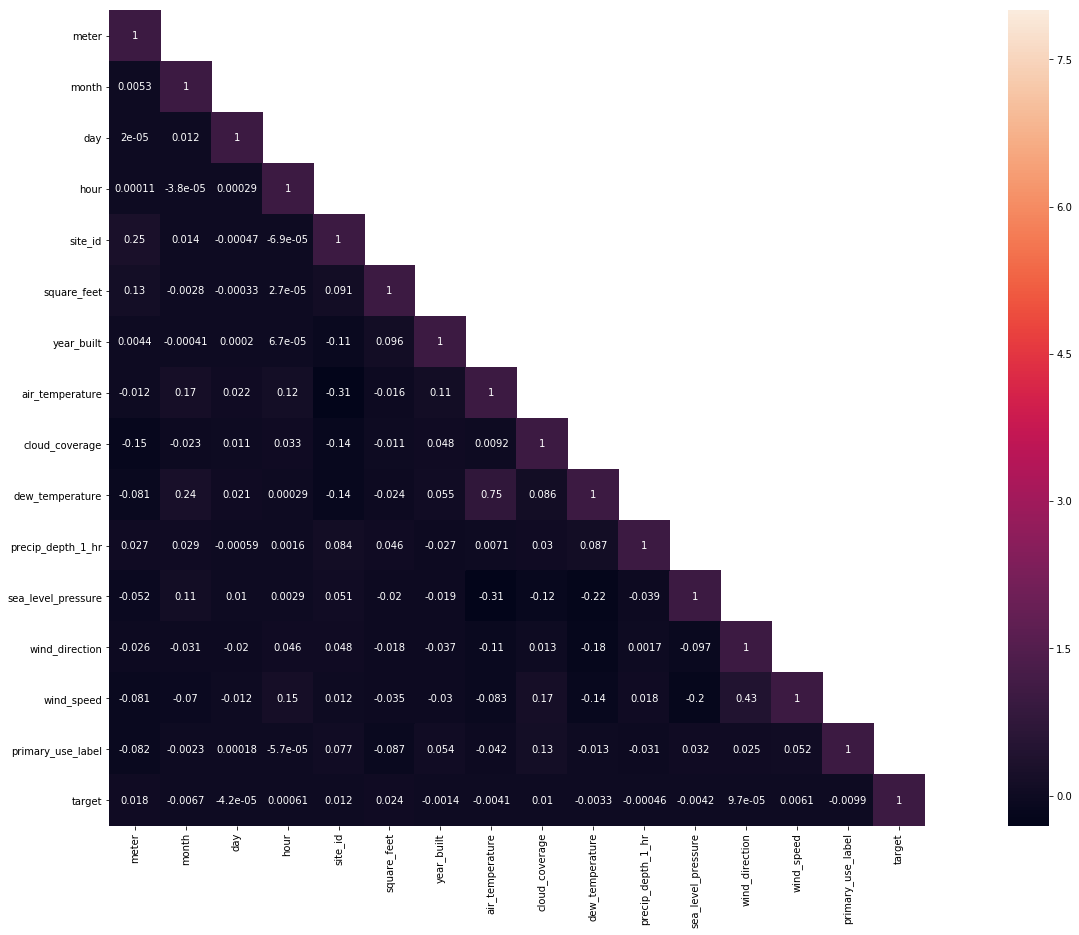

In [49]:
corrMatt = merge_train[merge_train.columns]
corrMatt = corrMatt.corr()
#print(corrMatt)
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

# corrMatt의 데이터가 어떤 relation이 있는지 확인
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.heatmap(corrMatt, mask=mask, vmax=8, square=True, annot=True)

In [48]:
merge_train.to_csv('merge_train_data.csv')

# 5. 데이터 모델링

### train / test data set

In [51]:
features = merge_train.columns
data_x = merge_train[features[0:len(features)-1]]

In [52]:
data_x.head(5)

,meter,month,day,hour,site_id,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use_label
0,0,1,1,0,0,7432,2008.0,25.0,6.0,20.0,-0.17,1019.7,0.0,0.0,0
1,0,1,1,0,0,2720,2004.0,25.0,6.0,20.0,-0.17,1019.7,0.0,0.0,0
2,0,1,1,0,0,5376,1991.0,25.0,6.0,20.0,-0.17,1019.7,0.0,0.0,0
3,0,1,1,0,0,23685,2002.0,25.0,6.0,20.0,-0.17,1019.7,0.0,0.0,0
4,0,1,1,0,0,116607,1975.0,25.0,6.0,20.0,-0.17,1019.7,0.0,0.0,0


In [53]:
data_y = merge_train["target"]
data_y.head(5)

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
trainingData_features, testData_features, trainingData_labels,testData_lables = \
train_test_split(data_x, data_y, test_size = 0.2, random_state = 2)

In [56]:
print(trainingData_features.shape)
print(testData_features.shape)
print(trainingData_labels.shape)
print(testData_lables.shape)

(16172880, 15)
(4043220, 15)
(16172880,)
(4043220,)


In [57]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [62]:
def base_model():
    model = Sequential()
    model.add(Dense(16,kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu', input_shape=(len(features)-1,)))
    model.add(Dropout(0.2))

    model.add(Dense(32,kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64,kernel_initializer='random_uniform',bias_initializer='zeros', activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32,kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(8,kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam()
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_absolute_error', 'mean_squared_error'])
    return model


In [63]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

In [69]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [70]:
callbacklist = [
    ModelCheckpoint(filepath="./ashrae_model.h5", monitor="loss",save_best_only=True )
]


In [71]:
my_model = KerasRegressor(build_fn=base_model, epochs=5, batch_size=100,verbose=0,callbacks=callbacklist)    

In [ ]:
history = my_model.fit(trainingData_features, trainingData_labels) 

# 6. 모델 추론

In [ ]:
import math
# loss,mae , rmse 결과 확인
loss, mae, mse = model.evaluate(testData_features , testData_label , verbose=0)
print(mae) 
print(math.sqrt(mse))

# Test 데이터 전처리

In [ ]:
primary_use_label = primary_use.to_dict()
primary_use_label = primary_use_label["primary_use_label"]
primary_use_label

## TEST 데이터 Merge

In [ ]:
merge_test = pd.merge(merge_test, weather_test,how="left",on=["site_id","timestamp"])
merge_test.head(5)

In [ ]:
merge_test["year"] = (merge_test["timestamp"].str[:4]).astype(int)
merge_test["month"] = (merge_test["timestamp"].str[5:7]).astype(int)
merge_test.head(10)

In [ ]:
msno.matrix(merge_test.sample(1000))

In [ ]:
merge_test.isna().sum()